In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from utils.utilities import result_object
from utils.load import load_everthing, load_everthing_with_distance, load_all_distance_metrics
import numpy as np
from utils.ml_models import lasso, lasso_pca, rf, rf_pca
from utils.utilities import bootstrap_all_distance_metrics, bootstrap, gen_feature_dict_lasso, gen_feature_dict_rf
from utils.plots import plot_confidence_interval
from utils.plots import plot_r2
import warnings
warnings.filterwarnings('ignore')

In [2]:
def loader(with_distance, all_dist_metrics):
    """This function simply loads our data"""
    test_size = 0.2
    val_size = 0
    if all_dist_metrics:
        x,y = load_all_distance_metrics(test_size = test_size, val_size = val_size, with_distance = with_distance)
    else:
        if with_distance:
            x,y = load_everthing_with_distance(test_size = test_size, val_size = val_size)
        else:
            x,y = load_everthing(test_size = test_size, val_size = val_size)
    return x,y
def process(x,y):
    """This function converts the data into the train and test data. It also performs log transormation of labels(Y)"""
    if "CosDist" in x["train"]:
        x_train = dict()
        x_test = dict()
        for distance_metric, val in x["train"].items():
            x_train_temp = list(val.values())
            x_train[distance_metric] = x_train_temp
        for distance_metric, val in x["test"].items():
            x_test_temp = list(val.values())
            x_test[distance_metric] = x_test_temp
    else:
        x_train = x["train"]
        x_test = x["test"]
        x_train = list(x_train.values())
        x_test = list(x_test.values())
    y_train = y["train"]
    y_test = y["test"]
    y_train = [np.log10(x[0]) for x in list(y_train.values())]
    y_test = [np.log10(x[0]) for x in list(y_test.values())]
    return x_train, y_train, x_test, y_test
def gridsearch(x_train,y_train, pipeline, param_grid,distance_metric,with_distance):
    print("running gridsearch")
    search = GridSearchCV(pipeline, param_grid, n_jobs=2,scoring= "r2")

    search.fit(x_train, y_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    obj = result_object(search, distance_metric,x_train,y_train,"world",with_distance, save_model= False)
    print("-"*75)
    return obj

def run_confidence_interval(pipeline, param_grid,distance_metric, with_distance, all_distance_metrics, title):
    n = 5
    if "Lasso_regressor" == pipeline.steps[-1][0]:
        feature_dict_function = gen_feature_dict_lasso
    elif "rf" == pipeline.steps[-1][0]:
        feature_dict_function = gen_feature_dict_rf
    
    if all_distance_metrics:
        s = bootstrap_all_distance_metrics(pipeline= pipeline, param_grid= param_grid,with_dist= with_distance, n = n)
        feature_dict = feature_dict_function(s, with_dist= with_distance, all_distance= all_distance_metrics)
        feature_dict = dict( sorted(feature_dict.items(), key=lambda x: x[0].lower()) )
    else:
        s = bootstrap(pipeline= pipeline, param_grid= param_grid,distance_metric=distance_metric,with_dist= with_distance, n = n)
        feature_dict = feature_dict_function(s, with_dist= with_distance)
    plot_confidence_interval(feature_dict,title)

def naming(with_distance, with_all_dist_metrics, pipeline, distance_metrics = None):
    
    name = ""

    if "Lasso_regressor" == pipeline.steps[-1][0]:
        name+= "LASSO "
    elif "rf" == pipeline.steps[-1][0]:
        name+= "RF "
    
    if with_distance:
        name+= " with distance"
    if with_all_dist_metrics:
        name+= " all distance metrics"

    if "PCA" == pipeline.steps[-2][0]:
        name+= " with PCA" 
    
    if distance_metrics != None:
        name+= " " +distance_metrics
    return name
def do_everything(with_distance, with_all_dist_metrics, model):
    pipeline, param_grid = model()
    print(pipeline.steps)
    x,y = loader(with_distance, with_all_dist_metrics)
    x_train, y_train, x_test, y_test = process(x,y)
    #If we use all the dist metrics, then we dont loop and simply run gridsearch and so on

    if with_all_dist_metrics:
        name = naming(with_distance, with_all_dist_metrics, pipeline)

        distance_metric = "all"
        obj = gridsearch(x_train, y_train, pipeline, param_grid, distance_metric, with_distance)
        search = obj.gridsearch
        if "PCA" not in name:
            run_confidence_interval(pipeline, param_grid, distance_metric, with_distance,with_all_dist_metrics,f"Coefficient estimate {name}")
        pred = search.best_estimator_.predict(x_test)
        plot_r2(pred, y_test,f"Predicted vs labels {name}")
    else:
        for x_train_elm, x_test_elm in zip(x_train.items(), x_test.items()):

            distance_metric = x_train_elm[0]
            name = naming(with_distance, with_all_dist_metrics, pipeline,distance_metric)


            x_train_elm = x_train_elm[1]
            x_test_elm = x_test_elm[1]
            obj = gridsearch(x_train_elm, y_train, pipeline, param_grid, distance_metric, with_distance)
            search = obj.gridsearch
            run_confidence_interval(pipeline, param_grid, distance_metric, with_distance,with_all_dist_metrics,f"Coefficient estimate {name}")
            pred = search.best_estimator_.predict(x_test_elm)
            plot_r2(pred, y_test,f"Predicted vs labels {name}")

[('StandardScaler', StandardScaler()), ('Lasso_regressor', LassoCV(max_iter=100000, tol=0.001))]
running gridsearch
Best parameter (CV score=0.609):
{}
---------------------------------------------------------------------------
number of sample runs: 5
loading in data
running bootstrap
0


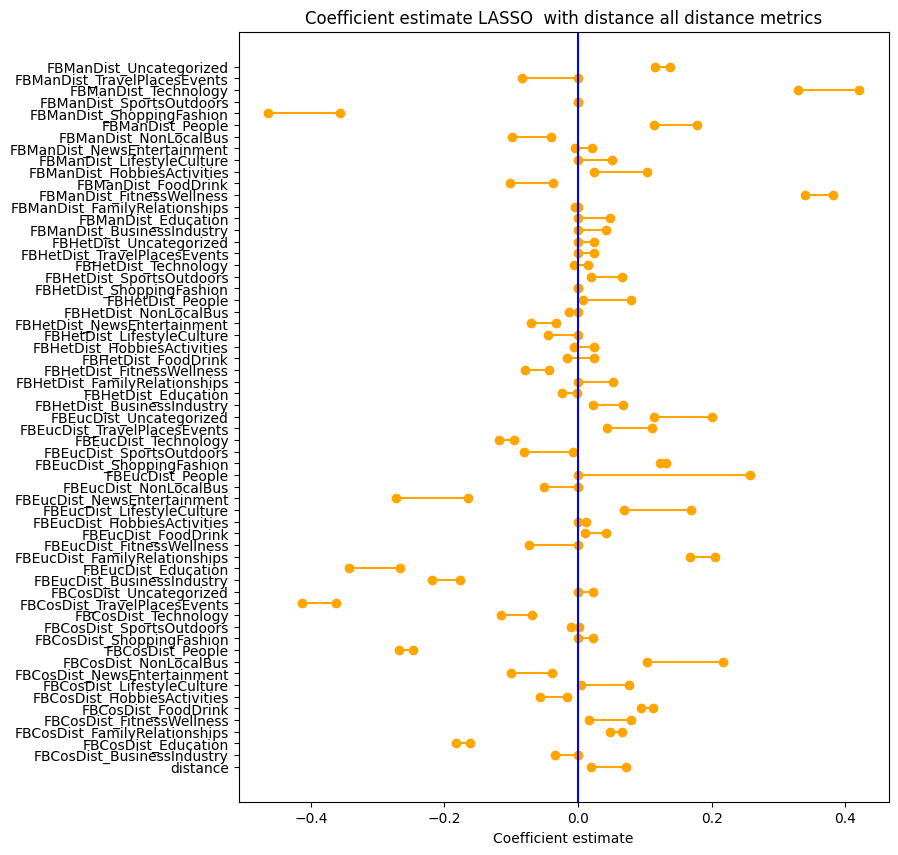

Predicted vs labels LASSO  with distance all distance metrics


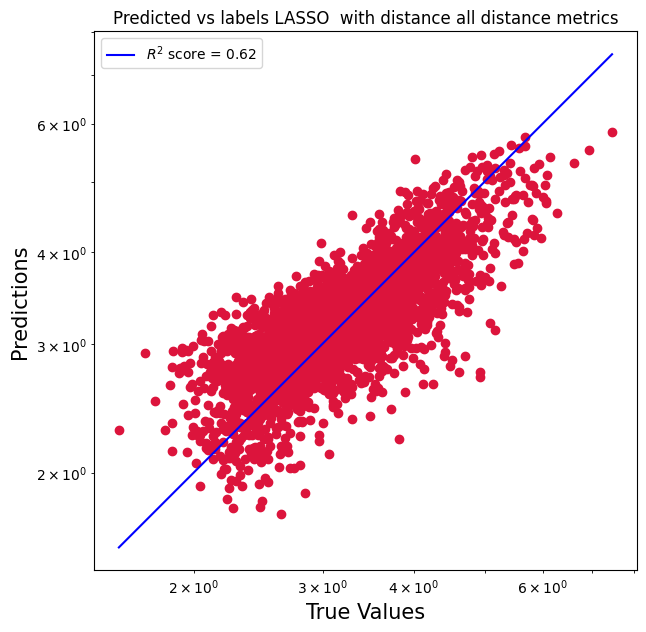

[('StandardScaler', StandardScaler()), ('PCA', PCA()), ('Lasso_regressor', LassoCV(max_iter=100000, tol=0.001))]
running gridsearch
Best parameter (CV score=0.600):
{'PCA__n_components': 38}
---------------------------------------------------------------------------
Predicted vs labels LASSO  with distance all distance metrics with PCA


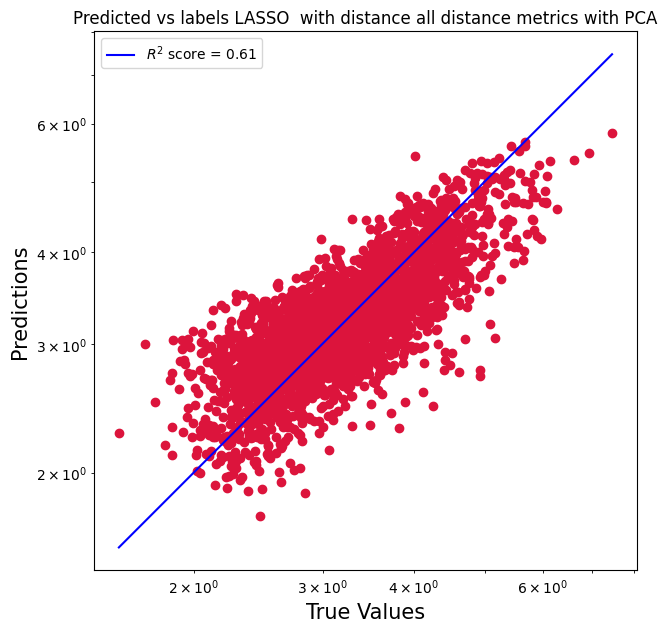

[('StandardScaler', StandardScaler()), ('rf', RandomForestRegressor())]
running gridsearch


In [3]:

def run():
    with_all_dist_metrics = [True,False] 
    with_distances = [True, False]
    models = [lasso, lasso_pca, rf, rf_pca]
    for all_dist_metric in with_all_dist_metrics:
        for with_distance in with_distances:
            for model in models:
                do_everything(with_distance, all_dist_metric, model)